# Prompt Tuning for Sentiment Classification (Financial Phrasebank)

- [ 1 - Set up Kernel, Load Required Dependencies, Dataset and LLM](#1)
  - [ 1.1 - Set up Required Dependencies and Imports](#1.1)
  - [ 1.2 - Load LLM - Facebook OPT 1.3B Model](#1.2)
  - [ 1.3 - Load ESG-Prospectus-Clarity-Category Dataset](#1.3)
- [ 2 - Finetuning Model](#2)
  - [ 2.1 - Creating Tokenized Dataset](#2.1)
  - [ 2.2 - Setting Hyperparameters & Training Model](#2.2)
  - [ 2.3 - Evaluate the Model Quantitatively (with Accuracy, Precision, Recall, F1, Confusion Matrix)](#2.3)

<a name='1'></a>
## 1 - Set up Login, Load Required Dependencies, Dataset and LLM

<a name='1.1'></a>
### 1.1 - Set up Kernel and Required Dependencies

In [1]:
#!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 sentencepiece xformers evaluate

In [2]:
# %pip install peft

import argparse
import os
import torch

from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaTokenizerFast, set_seed
from transformers import OPTForSequenceClassification, AutoTokenizer

from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    PeftType,
    PromptTuningConfig,
    TaskType
)

import evaluate
from datasets import load_dataset

from tqdm import tqdm

2023-09-21 05:55:40.895508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 05:55:41.723608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a name='1.2'></a>
### 1.2 - Load LLM - Facebook OPT 1.3B Model

In [3]:
model_name_or_path = "facebook/opt-1.3b"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
peft_config = PromptTuningConfig(task_type=TaskType.SEQ_CLS, num_virtual_tokens=10)

In [5]:
model = OPTForSequenceClassification.from_pretrained(model_name_or_path, return_dict=True, num_labels=3, torch_dtype=torch.bfloat16, device_map='auto')
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 32,768 || all params: 1,315,790,848 || trainable%: 0.0024903653988631483


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side='left')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.vocab_size

50265

<a name='1.3'></a>
### 1.3 - Load Sentiment Dataset: Financial Phrasebank

In [7]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [8]:
sentiment_dataset = load_dataset("financial_phrasebank", 'sentences_allagree', split='train')
sentiment_df = sentiment_dataset.to_pandas()
X_train, X_test, y_train, y_test = train_test_split(sentiment_df.sentence.tolist(), sentiment_df.label.tolist(), 
                                                    test_size=0.2, stratify=sentiment_df.label.tolist(), random_state=42)
len(X_test), len(y_test)

(453, 453)

In [9]:
min(y_train), max(y_train), y_train.count(2)

(0, 2, 456)

<a name='2'></a>
## 2 - Finetuning Model

<a name='2.1'></a>
### 2.1 - Create Tokenized Dataset

In [11]:
train_encodings = tokenizer(X_train, padding="longest")
test_encodings = tokenizer(X_test, padding="longest")

In [12]:
class FinanceSentiment(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [13]:
train_dataset = FinanceSentiment(train_encodings, y_train)
test_dataset = FinanceSentiment(test_encodings, y_test)

<a name='2.2'></a>
### 2.2 - Setting Hyperparameters & Training Model

In [14]:
from transformers import Trainer, TrainingArguments
from torch import nn

In [15]:
model_name = "llama-prompttuned"
training_args = TrainingArguments(output_dir=model_name,
                                  learning_rate=1e-3,
                                  save_strategy='steps',
                                  num_train_epochs=20,
                                  seed=42,
                                  data_seed=43,
                                  logging_strategy='epoch',
                                  per_device_train_batch_size=16)

In [16]:
from transformers import logging
logging.set_verbosity_error()

In [17]:
peft_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer
)
peft_trainer.train()

/home/dsp/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
114,0.772500
228,0.570100
342,0.503500
456,0.403400
570,0.374100
684,0.339900
798,0.296000
912,0.260000
1026,0.240600
1140,0.239700


TrainOutput(global_step=2280, training_loss=0.2890758648253324, metrics={'train_runtime': 838.8454, 'train_samples_per_second': 43.178, 'train_steps_per_second': 2.718, 'total_flos': 3.467061743321088e+16, 'train_loss': 0.2890758648253324, 'epoch': 20.0})

In [18]:
preds_output_test = peft_trainer.predict(test_dataset)

In [19]:
preds_output_test.metrics

{'test_loss': 0.23574607074260712,
 'test_runtime': 7.1933,
 'test_samples_per_second': 62.976,
 'test_steps_per_second': 7.924}

<a name='2.3'></a>
### 2.3 - Evaluate the Model Quantitatively (with Accuracy, Precision, Recall, F1, Confusion Matrix)

In [25]:
import numpy as np
y_pred_test = np.argmax(preds_output_test.predictions, axis=1)

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

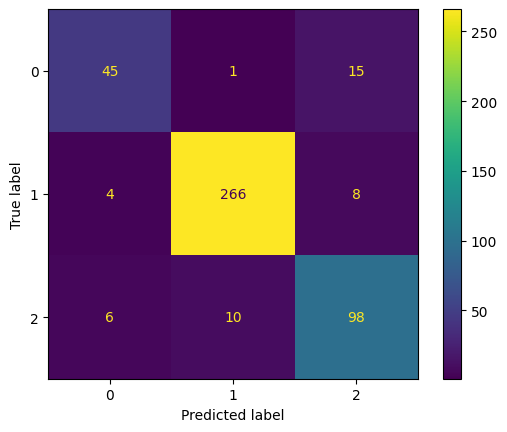

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def compute_metrics(labels, preds):
    
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    
    return {'accuracy': acc, 'precision':precision, 'recall':recall, 'f1':f1}

In [29]:
compute_metrics(y_test, y_pred_test)

{'accuracy': 0.9028697571743929,
 'precision': 0.8627959940726596,
 'recall': 0.8513961910713017,
 'f1': 0.8561543935718551}